In [0]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
import torchvision.datasets as dsets 
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from keras.utils import *
import random
import math
import os
from torchvision import datasets, transforms
from torch import nn, optim
import seaborn
import torch
import torch.nn.functional as F
from pylab import *
# from nano.pytorch import helper
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


In [0]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
seaborn.set(style="whitegrid",
            rc={"axes.grid": False,
                "font.family": ["sans-serif"],
                "font.sans-serif": ["Latin Modern Sans", "Lato"],
                "figure.figsize": (8, 6)},
            font_scale=1)

In [0]:
epochs = 25;
batch_size = 128;
learning_rate = 0.001;

In [0]:
means = (0.5, 0.5, 0.5)
deviations = means
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 transform=transform)


train_size = int(0.9 * len(full_train_dataset))
validation_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, validation_size])


train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)


test_dataset = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)



In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


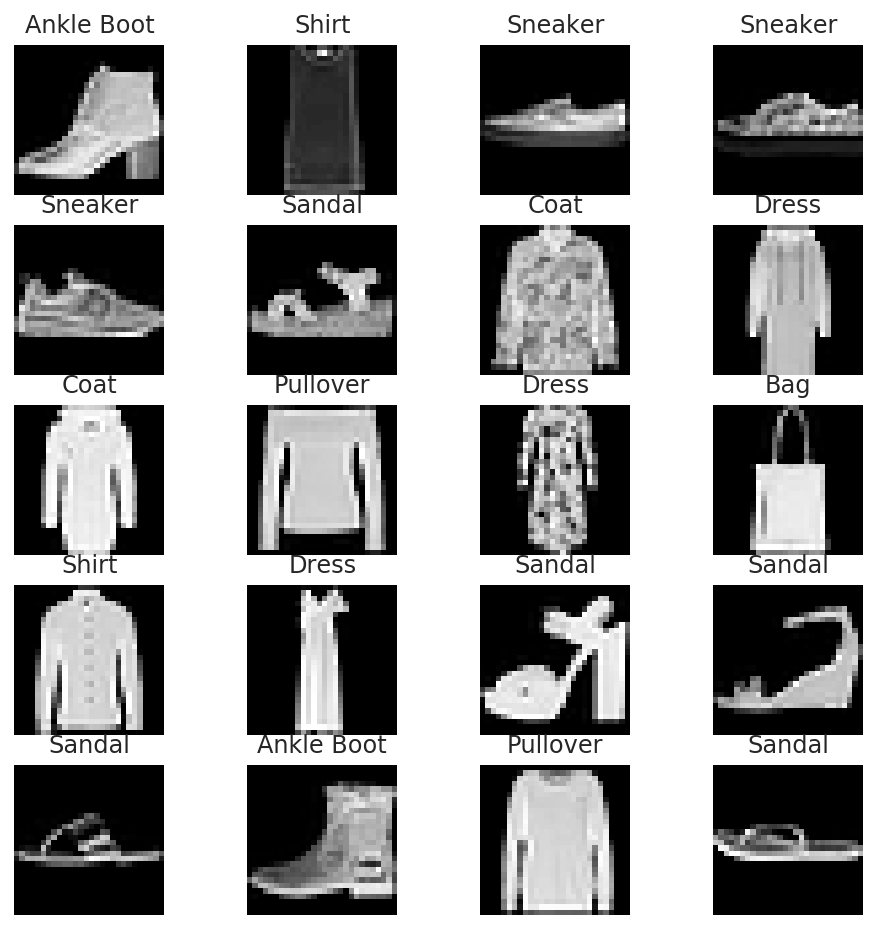

In [0]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
cnn = CNN().to(device);
# cnn = CNN()
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

losses = [];

In [0]:
train_losses, validation_losses = [],[]
for e in range(epochs):
    train_loss = 0
    validation_loss = 0
    accuracy = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) ## Move to Cuda
        optimizer.zero_grad()
        op = cnn(images)
        loss = criterion(op, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            cnn.eval()
            for images,labels in validate_loader:
                images, labels = images.to(device), labels.to(device) ## Move to Cuda
                log_ps = cnn(images)
                prob = torch.exp(log_ps)
                top_probs, top_classes = prob.topk(1, dim=1)
                equals = labels == top_classes.view(labels.shape)
                accuracy += equals.type(torch.FloatTensor).mean()
                validation_loss += criterion(log_ps, labels)
        cnn.train()
    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
              "validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
              "validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
    train_losses.append(train_loss/len(train_loader))
    validation_losses.append(validation_loss/len(train_loader))

Epoch: 1/25..  Training Loss: 0.425..  validation Loss: 0.318..  validation Accuracy: 0.889
Epoch: 2/25..  Training Loss: 0.302..  validation Loss: 0.295..  validation Accuracy: 0.895
Epoch: 3/25..  Training Loss: 0.259..  validation Loss: 0.270..  validation Accuracy: 0.903
Epoch: 4/25..  Training Loss: 0.236..  validation Loss: 0.258..  validation Accuracy: 0.907
Epoch: 5/25..  Training Loss: 0.218..  validation Loss: 0.261..  validation Accuracy: 0.907
Epoch: 6/25..  Training Loss: 0.205..  validation Loss: 0.242..  validation Accuracy: 0.917
Epoch: 7/25..  Training Loss: 0.192..  validation Loss: 0.243..  validation Accuracy: 0.911
Epoch: 8/25..  Training Loss: 0.175..  validation Loss: 0.267..  validation Accuracy: 0.906
Epoch: 9/25..  Training Loss: 0.166..  validation Loss: 0.242..  validation Accuracy: 0.919
Epoch: 10/25..  Training Loss: 0.157..  validation Loss: 0.242..  validation Accuracy: 0.919
Epoch: 11/25..  Training Loss: 0.145..  validation Loss: 0.249..  validation Ac

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

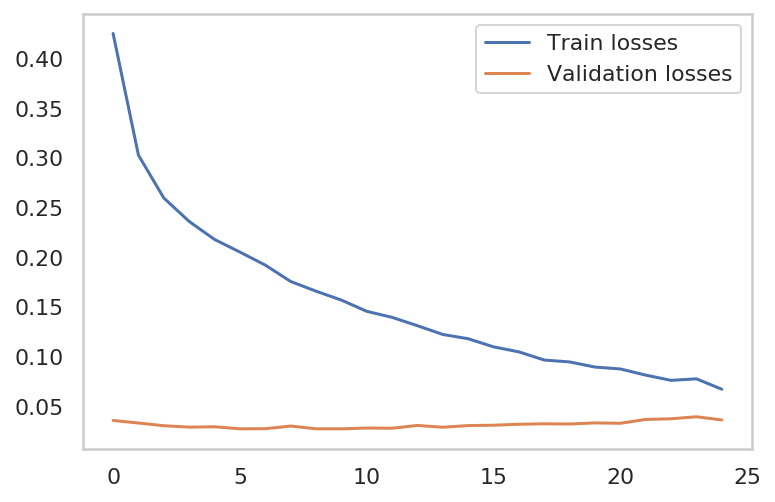

In [0]:
plt.plot(train_losses,label = "Train losses")
plt.plot(validation_losses, label = "Validation losses")
plt.legend()

In [0]:
cnn.eval()
correct = 0
total = 0
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device) ## Move to Cuda
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the training_set: %.4f %%' % (100 * correct / total))


correct = 0
total = 0
for images, labels in validate_loader:
    images, labels = images.to(device), labels.to(device) ## Move to Cuda
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the validation_set: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the training_set: 98.0000 %
Test Accuracy of the model on the validation_set: 91.0000 %


In [0]:
image,labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device) ## Move to Cuda

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.cpu().detach().numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')



In [0]:
def view_classify(img, ps, version="MNIST", title = 0):
    ''' Function for viewing an image and it's predicted classes.
    '''
    title_order = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
    # ps = ps.data.cpu()
    # img = img.cpu()
    ps = ps.data.cpu().detach().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().detach().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(title_order, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.0)
    plt.tight_layout()
    plt.title("True: " + title_order[title])

In [0]:

def display_test(k):
    cnn.eval()
    count = 0;
    for images, labels in test_loader:
      if(count <= k):
        images, labels = images.to(device), labels.to(device) ## Move to Cuda
        for i in range(0,len(images)):
          # print()/
          if(count>=k):
            break;
          with torch.no_grad():
              output = cnn.forward(images[i].unsqueeze(0))
              count=count+1;
    
          ps = torch.exp(output)
    # sys.exit(1)
          view_classify(images[i].view(1,28,28), ps, version='Fashion', title=labels[i])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Graphical prediction of 20 images from testing data set


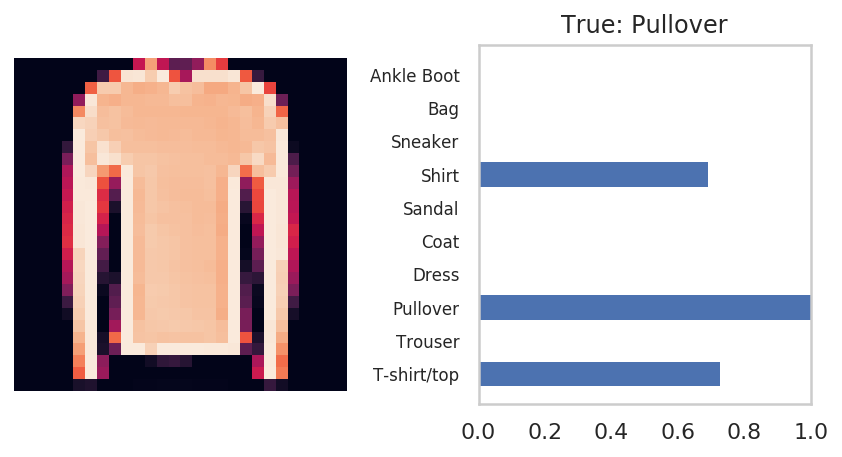

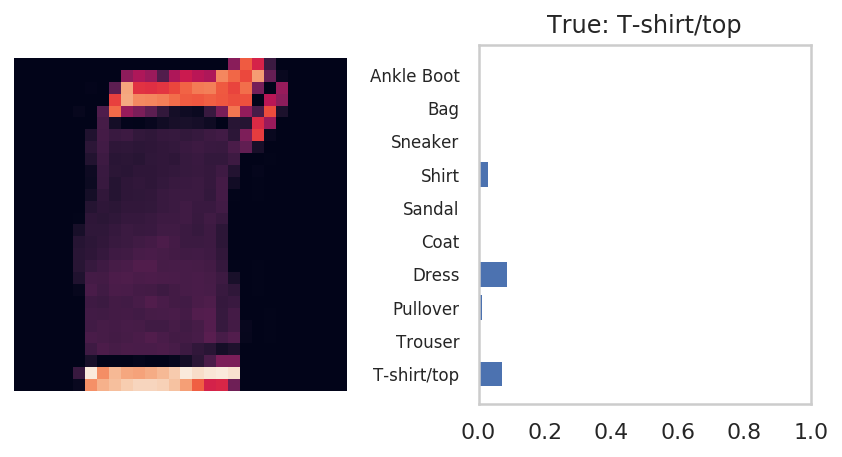

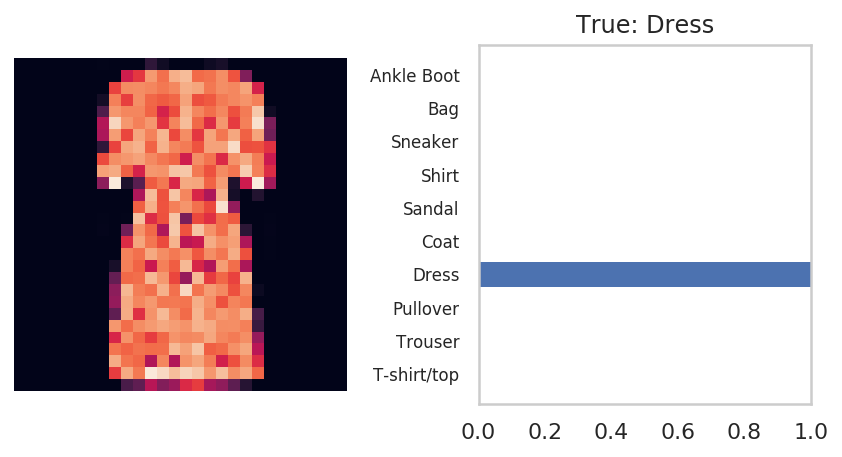

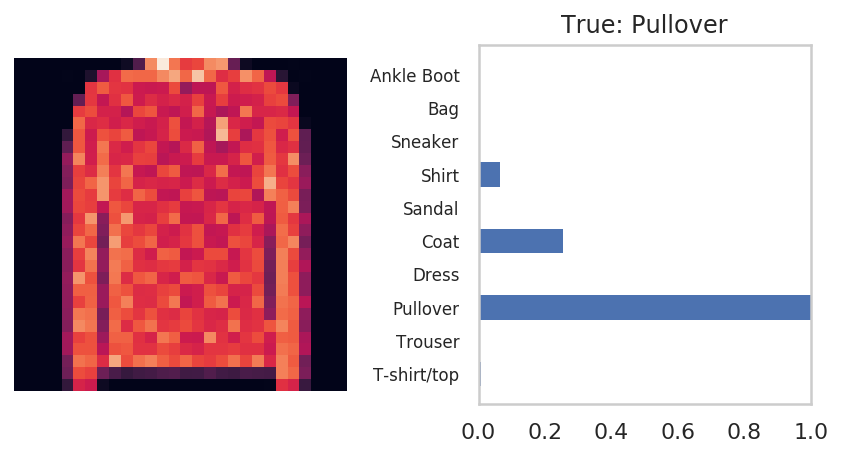

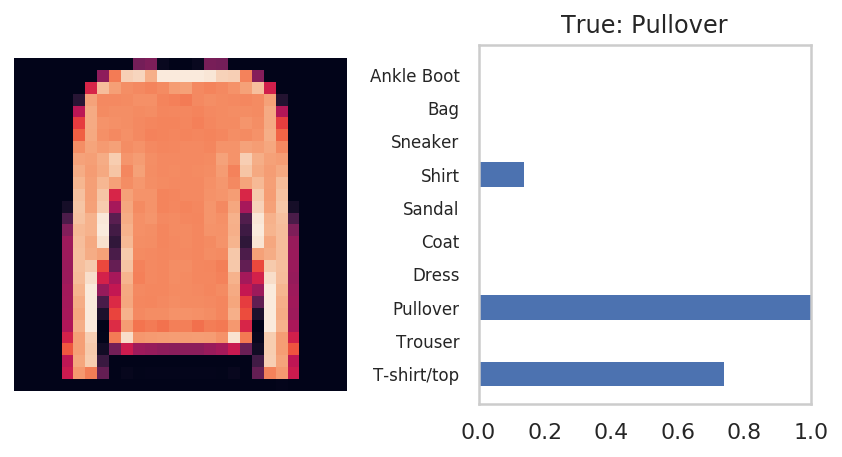

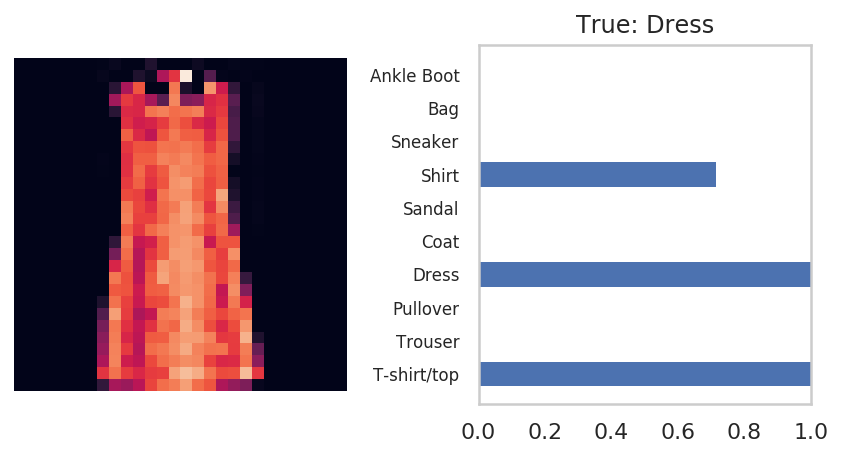

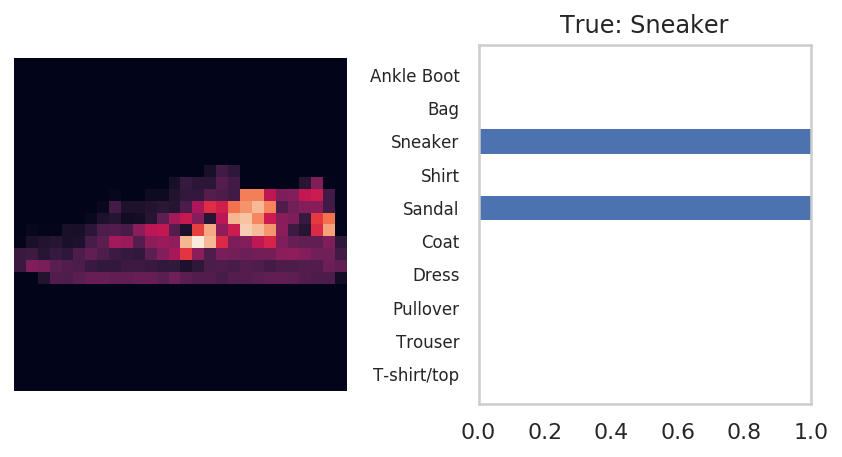

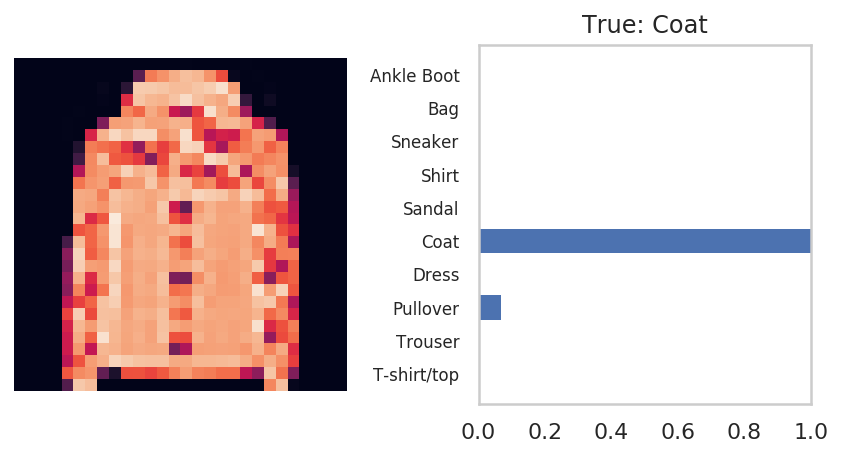

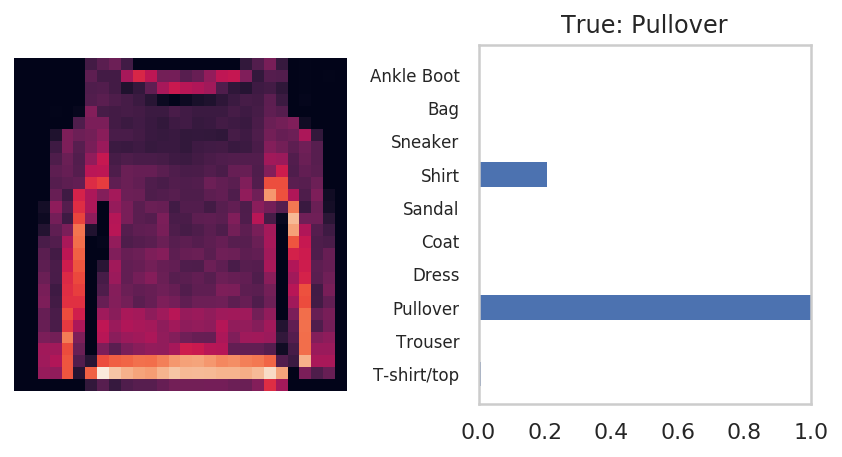

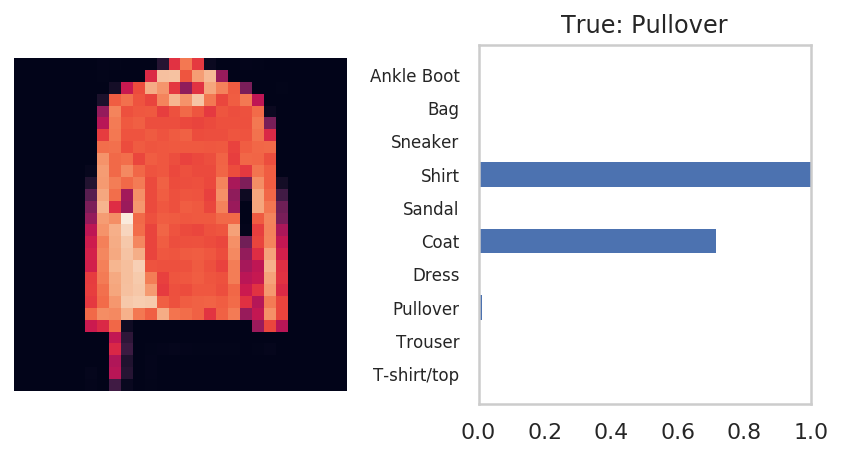

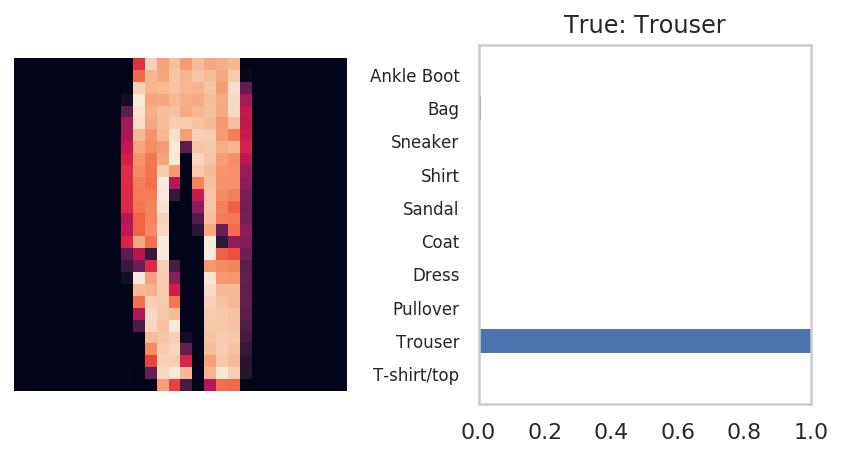

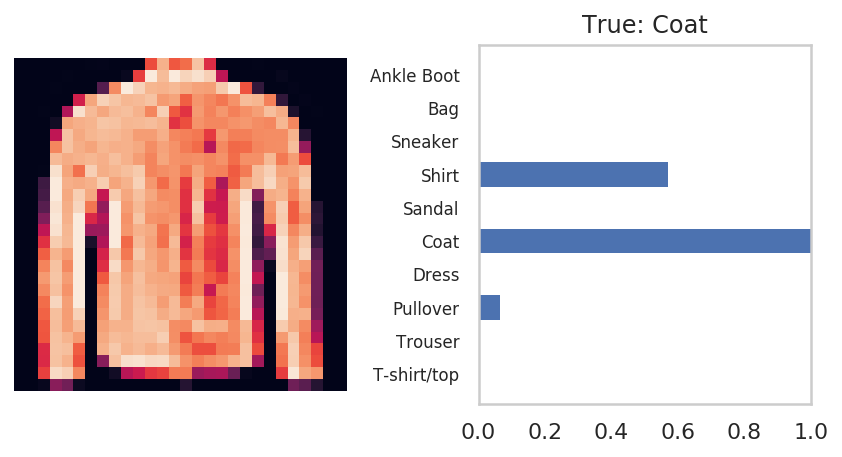

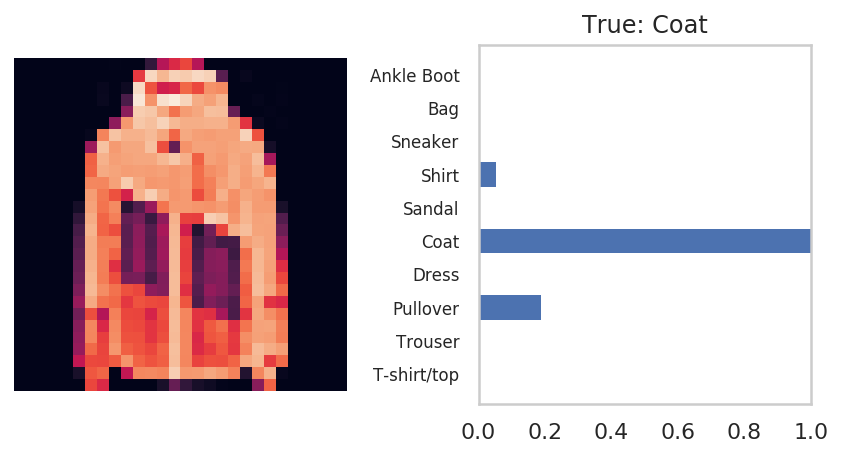

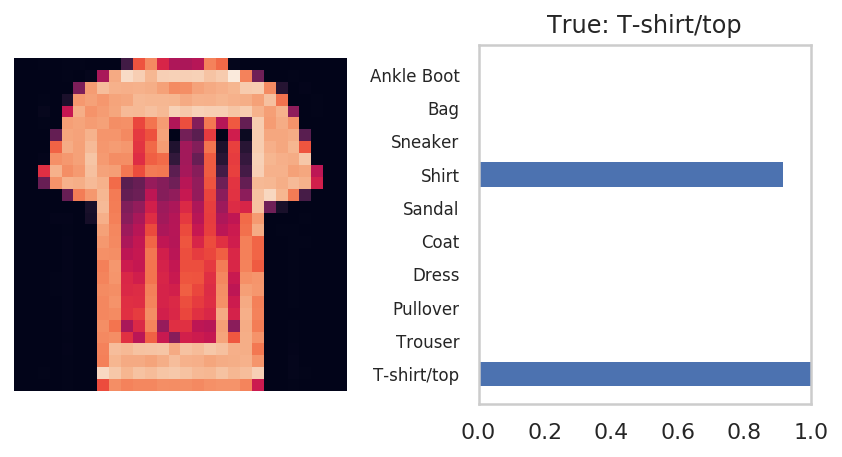

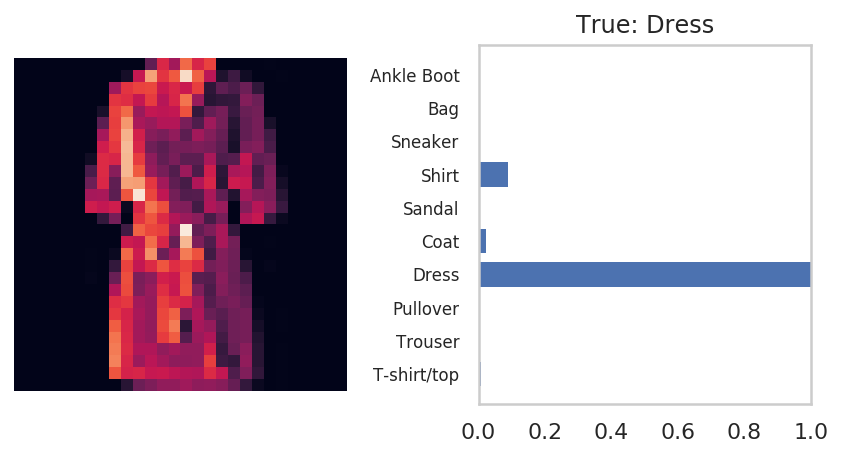

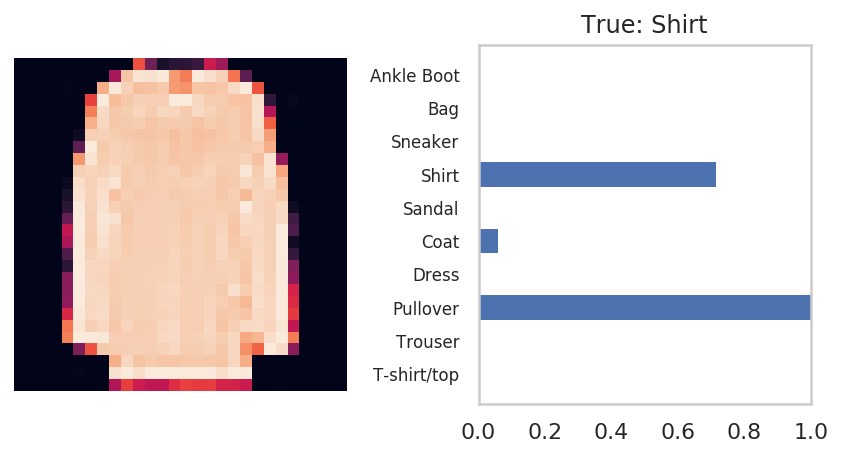

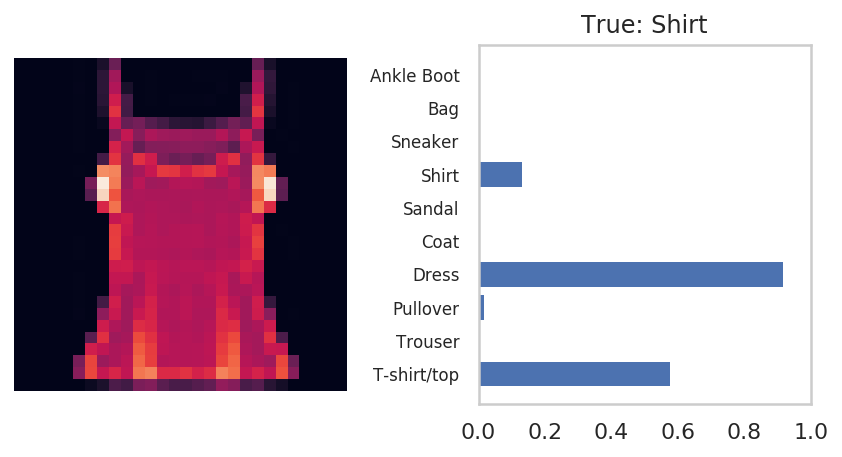

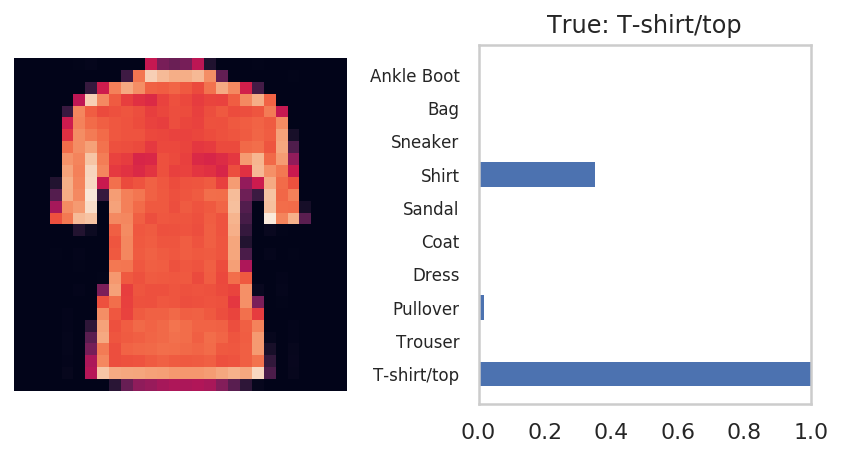

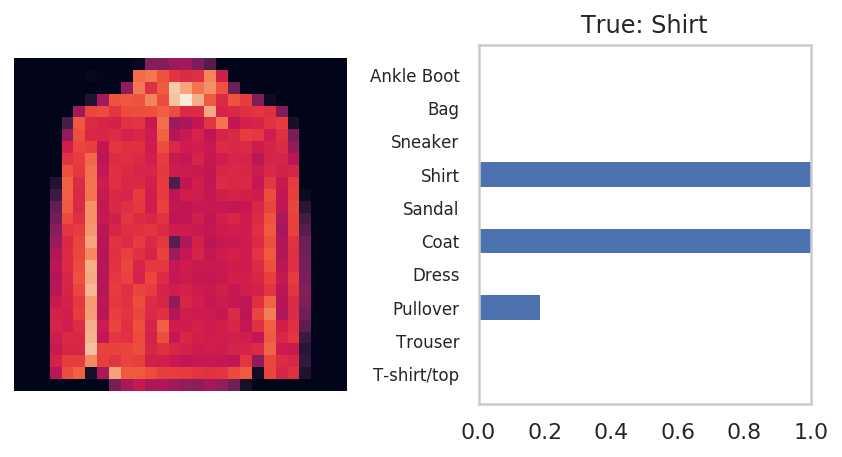

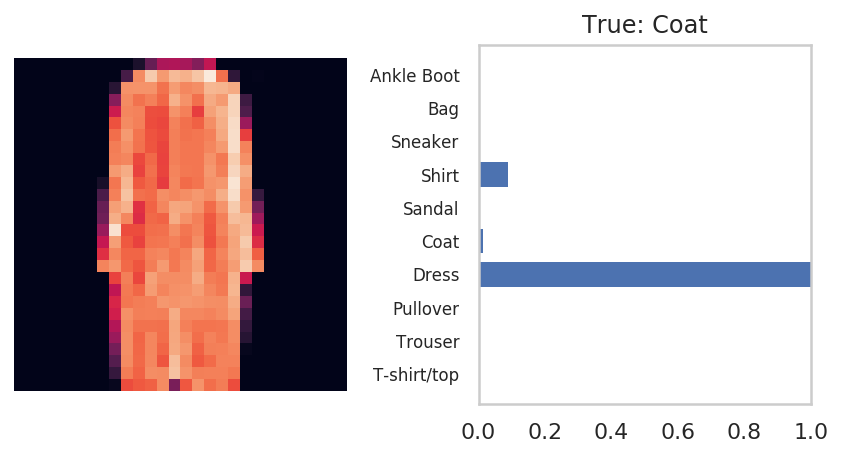

In [0]:
m = 20
display_test(m)  # No. of Images for predictions
print("Graphical prediction of 20 images from testing data set") #increase m if more test images needed.

In [0]:
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device) ## Move to Cuda
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    # print(labels)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the testing_set (consist of 1000+ images): %.4f %%' % (100 * correct / total))


Accuracy of the model on the testing_set (consist of 1000+ images): 90.0000 %
